<a href="https://colab.research.google.com/github/kmunozz/DataScienceProject2/blob/main/Analyzing_Factors_Influencing_Injury_Severity_in_Montgomery_County_Traffic_Collisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing Factors Influencing Injury Severity in Montgomery County Traffic Collisions

Kenia Munoz-Ordaz & Anh Le

12/17/2024

# Introduction

Traffic collisions are a leading cause of injuries and fatalities worldwide and are a significant challenge to public safety. Understanding the factors contributing to the severity of injuries in traffic collisions is crucial for improving road safety and implementing effective preventive measures.
This project uses a dataset collected from Montgomery County, Maryland through the Automated Crash Reporting System (ACRS): https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Drivers-Data/mmzv-x632/about_data. The dataset contains detailed information about 188,800 traffic collisions and includes 39 variables spanning various details of each crash. Key variables include environmental conditions, vehicle characteristics, and road factors, offering a clear understanding and view of the circumstances surrounding each collision.

In this analysis, we focus on the following predictor variables:


*   Speed Limit: The posted speed limit at the crash location.
*   Weather: Conditions such as clear, cloudy, rainy, or snowy during the crash.
*   Surface Condition: Road conditions like dry, wet, icy, or snow-covered.
*   Vehicle Body Type: Types of vehicles involved, such as passenger cars, trucks, buses, or motorcycles.

The target variable for this project is Injury Severity, which categorizes injury outcomes into levels such as no apparent injury, minor injury, serious injury, and fatal injury. By analyzing the relationships between the selected predictor variables and injury severity, we aim to identify patterns and factors that significantly influence the severity of injuries in traffic collisions. This project implements machine learning, specifically classification models, to predict the severity of injuries based on the selected variables.

# Initial Data Exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score
from sklearn.cluster import KMeans

In [ ]:
input_file = "https://raw.githubusercontent.com/alexknite/cst383-project2/refs/heads/main/03122024_Crash_Reporting_Data.csv"
df = pd.read_csv(input_file, low_memory=False)

It's important to explore the data and extract some key insights. We achieve this by using methods like .info( ), .describe ( ), and .sample( ).

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188800 entries, 0 to 188799
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Report Number                  188800 non-null  object 
 1   Local Case Number              188800 non-null  object 
 2   Agency Name                    188800 non-null  object 
 3   ACRS Report Type               188800 non-null  object 
 4   Crash Date/Time                188800 non-null  object 
 5   Route Type                     170344 non-null  object 
 6   Road Name                      169299 non-null  object 
 7   Cross-Street Name              162424 non-null  object 
 8   Off-Road Description           17418 non-null   object 
 9   Municipality                   19126 non-null   object 
 10  Related Non-Motorist           6065 non-null    object 
 11  Collision Type                 188215 non-null  object 
 12  Weather                       

This output provides an overview of the dataset, which contains 188,800 entries and 39 columns. Each column represents a variable related to traffic collisions. The maximum number of non-null entries in any column is 188,800, indicating complete data for variables like Report Number and Speed Limit.


Here are descriptions of some of the relevant variables we will be using:

| Variable | Description |
| :- | :- |
| Speed limit | Vehicle Circumstances - Local area posted speed limit. |
| Surface condition | Condition of roadway surface. |
| Crash Date/Time  | Date and Time of crash. |
| Driver At fault | Whether this driver was at fault.|
| Driver Substance Abuse | Substance abuse detected for all drivers involved.|
| Drivers License State | The state the driver's license was issued.|
| Vehicle Body Type | They body type of the vehicle. |
| Driverless vehicle | Vehicle Circumstances - If the vehicle was driverless or not |


In [ ]:
df.describe()

,Speed Limit,Vehicle Year,Latitude,Longitude
count,188800.000000,188800.000000,188800.000000,188800.000000
mean,32.382283,1965.951610,39.083166,-77.112265
std,11.180034,340.035724,0.071948,0.098383
min,0.000000,0.000000,37.720000,-79.486000
25%,25.000000,2006.000000,39.024481,-77.189504
50%,35.000000,2012.000000,39.074933,-77.105314
75%,40.000000,2016.000000,39.139924,-77.039278
max,75.000000,9999.000000,39.990414,-75.527708


The df.describe() output provides summary of statistics for the numerical columns in the dataset. For example, the speed limit ranges from 0 to 75 mph, with a mean of 32.38 mph. Most crashes occurred in areas with speed limits between 25 mph and 40 mph. This summary provides an overview of the dataset’s numerical features and highlights potential areas for data preprocessing.

In [ ]:
df.sample(5)

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Name,Off-Road Description,Municipality,...,Vehicle Going Dir,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Latitude,Longitude,Location
74761,MCP2818003B,180001130,Montgomery County Police,Property Damage Crash,01/08/2018 02:31:00 PM,Maryland (State),COLESVILLE RD,SECOND AVE,NaN,NaN,...,East,15,No,No,2012,GILL,HY,38.994012,-77.030377,"(38.99401167, -77.03037667)"
101198,MCP2353003S,170501565,Montgomery County Police,Property Damage Crash,04/11/2017 12:06:00 PM,Maryland (State),OLD GEORGETOWN RD,TUCKERMAN LA,NaN,NaN,...,North,40,No,No,2016,VOLKSWAGON,JETTA,39.034725,-77.125153,"(39.034725, -77.12515333)"
11711,MCP22700011,230014436,Montgomery County Police,Property Damage Crash,03/25/2023 12:00:00 PM,Maryland (State),OLD GEORGETOWN RD,RAMP 6 FR IS 495 EB TO MD 187 SB,NaN,NaN,...,East,35,No,No,2022,HYUN,SD,39.015233,-77.118808,"(39.01523333, -77.11880833)"
17126,MCP2938001G,180060290,Montgomery County Police,Property Damage Crash,12/02/2018 09:24:00 PM,Maryland (State),UNIVERSITY BLVD W,PERRY AVE,NaN,KENSINGTON,...,North,35,No,No,2001,ACURA,MDX,39.033243,-77.073263,"(39.03324333, -77.07326333)"
156259,MCP06170001,15059074,MONTGOMERY,Injury Crash,11/19/2015 11:40:00 AM,Maryland (State),NORBECK RD,NORBECK BLVD,NaN,NaN,...,East,40,No,No,2010,FREIGHT,TRUCK,39.112656,-77.070143,"(39.1126557, -77.07014322)"


In [ ]:
df.isna().mean()

,0
Report Number,0.000000
Local Case Number,0.000000
Agency Name,0.000000
ACRS Report Type,0.000000
Crash Date/Time,0.000000
Route Type,0.097754
Road Name,0.103289
Cross-Street Name,0.139703
Off-Road Description,0.907744
Municipality,0.898697


This shows the percentage of null values for each column in the dataset. The target variable, Injury Severity, has a low proportion of missing values at approximately 0.55%. In contrast, columns like Non-Motorist Substance Abuse and Related Non-Motorist have extremely high percentages of missing values, at 97.39% and 96.79%. Other columns, such as Off-Road Description (90.77%) and Municipality (89.87%), also have amount of missing data. These findings highlight the need for targeted data cleaning and preprocessing to address missing values effectively.








In [ ]:
df['Collision Type'].value_counts()

,count
Collision Type,
SAME DIR REAR END,55759
STRAIGHT MOVEMENT ANGLE,30342
OTHER,19030
SAME DIRECTION SIDESWIPE,16227
SINGLE VEHICLE,15873
HEAD ON LEFT TURN,12926
Front to Rear,5027
SAME DIRECTION RIGHT TURN,3832
HEAD ON,3786


# Data Exploration and Visualization

Now is a good time to visualize some of these key variables to understand how their values are relevant to Injury Severity

Looking at target variable to see the distribution of injury severity

In [ ]:
df['Injury Severity'] = df['Injury Severity'].str.title()
df['Collision Type'] = df['Collision Type'].str.title()

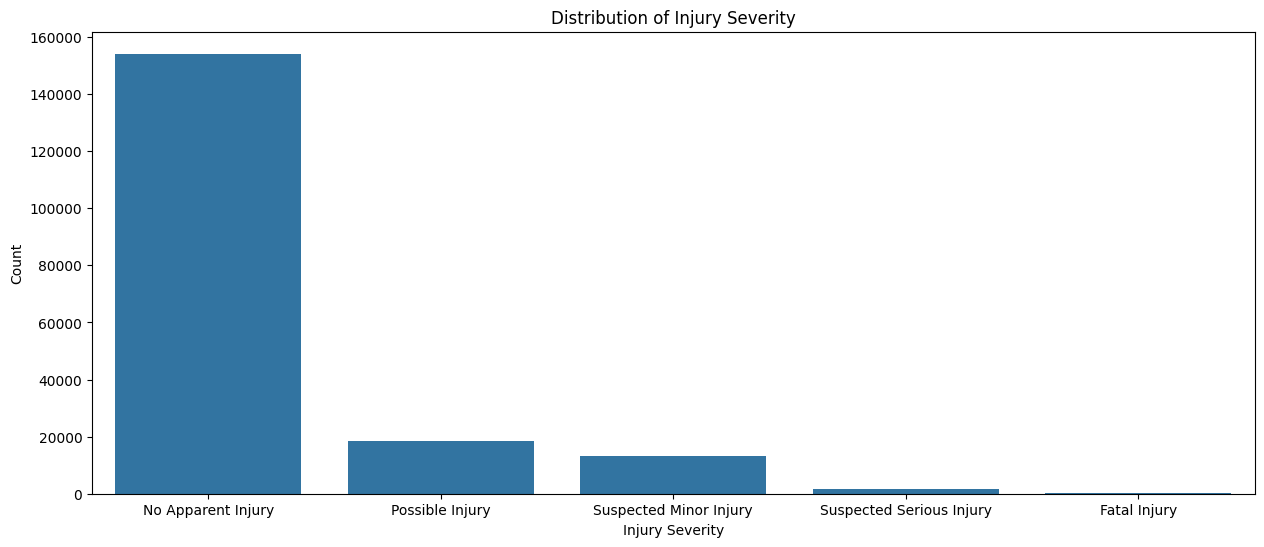

In [ ]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='Injury Severity', order=df['Injury Severity'].value_counts().index, orient='h')
plt.title('Distribution of Injury Severity')
plt.xlabel('Injury Severity')
plt.ylabel('Count')
plt.show()

The plot indicates that certain classes of injury severity occur significantly more often than others. For instance, categories such as "No Apparent Injury" may dominate the dataset, while categories like "Fatal Injury may be underrepresented." This might indicate that we are dealing with an imablanced target variable.

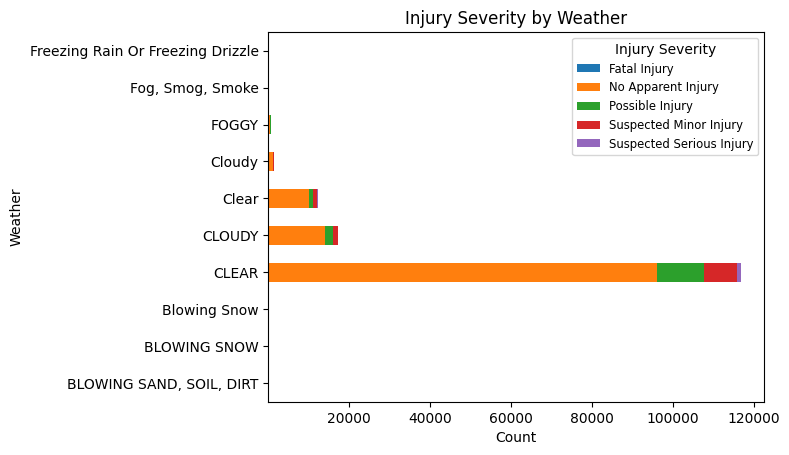

In [ ]:
pd.crosstab(df['Weather'], df['Injury Severity']).head(10).plot.barh(stacked=True)
plt.title('Injury Severity by Weather')
plt.xlabel('Count')
plt.ylabel('Weather')
plt.legend(title='Injury Severity', loc='upper right', fontsize = 'small')
plt.show()

This stacked horizontal bar plot shows that the majority of traffic collisions occur during clear weather conditions. Additionally, 'No Apparent Injury' is the most frequently reported injury severity across all weather types.

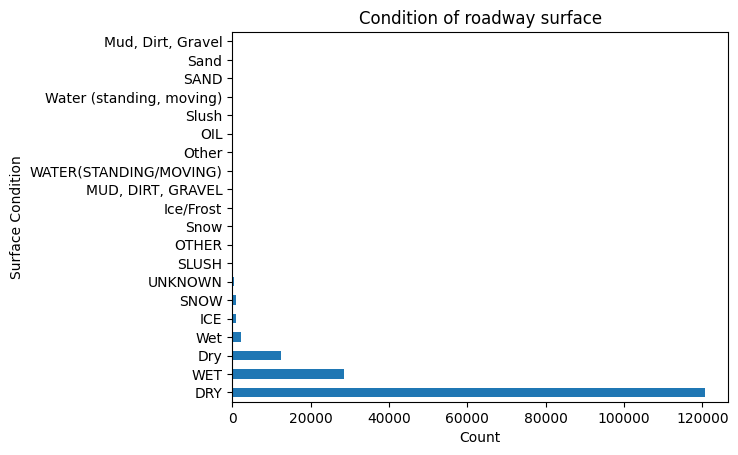

In [ ]:
df['Surface Condition'].value_counts().plot.barh()
plt.title('Condition of roadway surface')
plt.xlabel('Count')
plt.ylabel('Surface Condition')
plt.show()

This bar plot shows the distribution of traffic collisions across different roadway surface conditions. The vast majority of collisions occur on dry surfaces, followed by wet surfaces. Other conditions such as snow or ice are far less common, indicating that dry and wet roadways account for the majority of reported incidents.

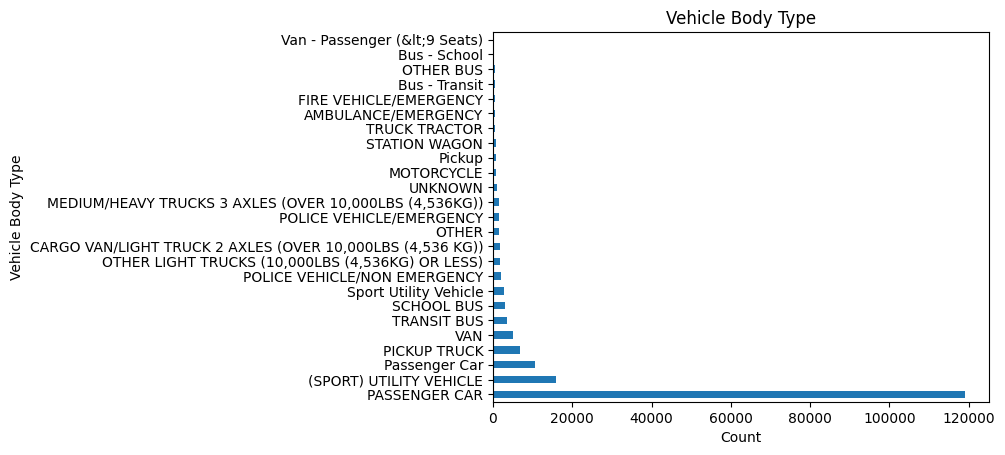

In [ ]:
df['Vehicle Body Type'].value_counts().head(25).plot.barh()
plt.title('Vehicle Body Type')
plt.xlabel('Count')
plt.ylabel('Vehicle Body Type')
plt.show()

This bar plot shows the distribution of traffic collisions by vehicle body type. Passenger cars account for the majority of vehicles involved in collisions,  indicating that passenger vehicles are the predominant type involved in traffic incidents.

Text(0.5, 1.0, 'Collision Type vs Injury Severity')

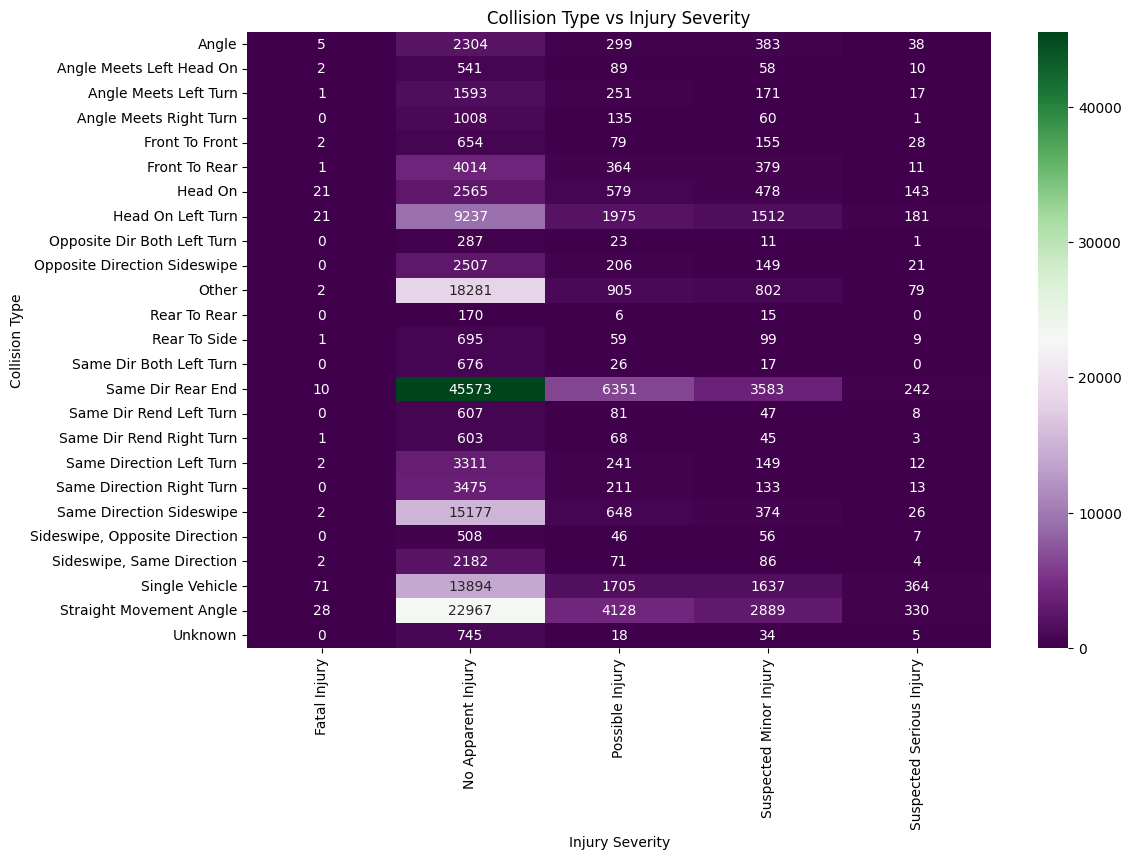

In [ ]:
heatmap_data = pd.crosstab(df['Collision Type'], df['Injury Severity'])
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='PRGn', annot=True, fmt='d', cbar=True)
plt.title('Collision Type vs Injury Severity')

This heat map graph shows how different directions or angles affect the severity of injury during car accidents. This helps show that most accidents especially rear ending caused the least injuries usually. We can use this to show how direction affects injury severity.

# Initial preprocessing and cleaning

Calculate the percentage of missing values for each column


In [ ]:
missing_data = df.isnull().mean() * 100
print(missing_data[missing_data > 0].sort_values(ascending=False))

Non-Motorist Substance Abuse     97.394597
Related Non-Motorist             96.787606
Off-Road Description             90.774364
Municipality                     89.869703
Circumstance                     81.043962
Driver Substance Abuse           16.588983
Traffic Control                  14.252648
Cross-Street Name                13.970339
Surface Condition                11.476695
Road Name                        10.328919
Route Type                        9.775424
Weather                           7.074153
Drivers License State             6.274364
Vehicle Going Dir                 2.877119
Vehicle Body Type                 1.495763
Parked Vehicle                    0.812500
Light                             0.765360
Driver Distracted By              0.592161
Injury Severity                   0.545551
Vehicle Movement                  0.494174
Collision Type                    0.309852
Vehicle Model                     0.266949
Vehicle Make                      0.244703
Vehicle Dam

To ensure dataset is clean, columns with more than 80% missing data are dropped

In [ ]:
threshold = 0.8
columns_to_drop = missing_data[missing_data > threshold * 100].index
df = df.drop(columns=columns_to_drop)
print(f"Dropped columns: {list(columns_to_drop)}")

Dropped columns: ['Off-Road Description', 'Municipality', 'Related Non-Motorist', 'Non-Motorist Substance Abuse', 'Circumstance']


Before proceeding, it’s important to check the distribution of our target variable to ensure it is balanced for modeling. Checking the value counts will help us determine if the data is balanced or if additional preprocessing steps are required to address class imbalance.

In [ ]:
df['Injury Severity'].value_counts()

,count
Injury Severity,
No Apparent Injury,154115
Possible Injury,18588
Suspected Minor Injury,13341
Suspected Serious Injury,1554
Fatal Injury,172


The distribution of the target variable, Injury Severity, shows a significant imbalance. The majority of entries fall into "No Apparent Injury", while more severe categories are underrepresented. This imbalance could affect model performance. To address this we converted the target variable into a binary classification problem, distinguishing between no injury and any level of injury.

In [ ]:
df['Injury_Binary'] = df['Injury Severity'].map({
    'No Apparent Injury': 0,
    'Possible Injury': 1,
    'Suspected Minor Injury': 1,
    'Suspected Serious Injury': 1,
    'Fatal Injury': 1
})

In [ ]:
df['Injury_Binary'].value_counts()

,count
Injury_Binary,
0.0,154115
1.0,33655


We crated the binary target variable, Injury_Binary, where 0 represents "No Apparent Injury" and 1 represents any level of injury. However, the distribution remains imbalanced, this imbalance can affect model performance by biasing predictions towards the majority class. To address this issue, we apply undersampling to create a balanced dataset.



In [ ]:
minority_rows = df[df['Injury_Binary'] == 1]
minority_count = minority_rows.shape[0]
majority_rows = df[df['Injury_Binary'] == 0].sample(minority_count,

replace=False)
df_balanced = pd.concat([majority_rows, minority_rows])
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

In [ ]:
df_balanced['Injury_Binary'].value_counts()

,count
Injury_Binary,
1.0,33655
0.0,33655


We will now take a look at our predictor variables and clean any duplicates.

In [ ]:
df_balanced['Weather'].value_counts()

,count
Weather,
CLEAR,41928
RAINING,7459
CLOUDY,6355
Clear,4303
Rain,636
SNOW,495
Cloudy,486
FOGGY,247
UNKNOWN,171


In [ ]:
df_balanced['Weather'] = df['Weather'].str.lower()
weather_mapping = {
    'clear': 'clear',
    'rain': 'rain',
    'cloudy': 'cloudy',
    'snow': 'snow',
    'foggy': 'fog',
    'wintry mix': 'snow',
    'other': 'other',
    'sleet': 'snow',
    'severe winds': 'storm',
    'blowing snow': 'snow',
    'unknown': 'unknown',
    'blowing sand, soil, dirt': 'storm',
    'severe crosswinds': 'storm',
    'sleet or hail': 'snow',
    'fog, smog, smoke': 'fog',
    'freezing rain or freezing drizzle': 'snow'
}

df_balanced['Weather'] = df_balanced['Weather'].map(lambda x: weather_mapping.get(x, 'unknown'))

After clean the duplicates, our data looks better

In [ ]:
df_balanced['Weather'].value_counts()

,count
Weather,
clear,45913
unknown,13568
cloudy,6555
snow,798
fog,263
other,149
storm,64


In [ ]:
df_balanced['Surface Condition'].value_counts()

,count
Surface Condition,
DRY,44583
WET,10511
Dry,4304
Wet,812
ICE,400
SNOW,317
UNKNOWN,126
SLUSH,85
OTHER,66


In [ ]:
df_balanced['Surface Condition'] = df_balanced['Surface Condition'].str.lower()
surface_condition_mapping = {
    'dry': 'dry',
    'wet': 'wet',
    'ice': 'ice',
    'snow': 'snow',
    'unknown': 'unknown',
    'slush': 'slush',
    'other': 'other',
    'ice/frost': 'ice',
    'mud, dirt, gravel': 'mud',
    'water(standing/moving)': 'water',
    'oil': 'oil',
    'sand': 'sand',
    'water (standing, moving)': 'water'
}
df_balanced['Surface Condition'] = df_balanced['Surface Condition'].map(lambda x: surface_condition_mapping.get(x, 'unknown'))

In [ ]:
df_balanced['Surface Condition'].value_counts()

,count
Surface Condition,
dry,48887
wet,11323
unknown,6096
ice,427
snow,344
slush,94
other,76
mud,27
water,21


In [ ]:
df_balanced['Vehicle Body Type'].value_counts()

,count
Vehicle Body Type,
PASSENGER CAR,44441
(SPORT) UTILITY VEHICLE,6044
Passenger Car,3647
PICKUP TRUCK,2108
VAN,1709
Sport Utility Vehicle,964
TRANSIT BUS,925
MOTORCYCLE,732
SCHOOL BUS,678


In [ ]:
df_balanced['Vehicle Body Type'] = df_balanced['Vehicle Body Type'].str.lower()
vehicle_body_mapping = {
    'passenger car': 'passenger car',
    '(sport) utility vehicle': 'sport utility vehicle',
    'pickup truck': 'pickup truck',
    'van': 'van',
    'transit bus': 'bus',
    'school bus': 'bus',
    'sport utility vehicle': 'sport utility vehicle',
    'police vehicle/non emergency': 'police vehicle',
    'other light trucks (10,000lbs (4,536kg) or less)': 'light truck',
    'cargo van/light truck 2 axles (over 10,000lbs (4,536 kg))': 'light truck',
    'other': 'other',
    'police vehicle/emergency': 'police vehicle',
    'medium/heavy trucks 3 axles (over 10,000lbs (4,536kg))': 'truck',
    'unknown': 'unknown',
    'motorcycle': 'motorcycle',
    'station wagon': 'station wagon',
    'truck tractor': 'truck',
    'ambulance/emergency': 'emergency vehicle',
    'fire vehicle/emergency': 'emergency vehicle',
    'bus - transit': 'bus',
    'other bus': 'bus',
    'bus - school': 'bus',
    'van - passenger (<9 seats)': 'van',
    'fire vehicle/non emergency': 'emergency vehicle',
    'recreational vehicle': 'other',
    'ambulance/non emergency': 'emergency vehicle',
    'other trucks': 'truck',
    'single-unit truck': 'truck',
    'snowmobile': 'other',
    'all terrain vehicle (atv)': 'other',
    'station wagon': 'station wagon',
    'moped': 'other',
    'low speed vehicle': 'other',
    'cross country bus': 'bus',
    'farm vehicle': 'other',
    'moped or motorized bicycle': 'other',
    'bus - other type': 'bus',
    'limousine': 'other',
    'construction equipment (backhoe, bulldozer, etc.)': 'other',
    'bus - mini': 'bus',
    'recreational off-highway vehicles (rov)': 'other',
    'snowmobile': 'other',
    'motorcycle - 3 wheeled': 'motorcycle',
    'bus - cross country': 'bus',
    'low speed vehicle': 'other',
    'farm equipment (tractor, combine harvester, etc.)': 'other',
    'autocycle': 'other',
    'van - passenger (9 or 12 seats)': 'van',
    'van - passenger (15 seats)': 'van'
}
df_balanced['Vehicle Body Type'] = df_balanced['Vehicle Body Type'].map(lambda x: vehicle_body_mapping.get(x, 'other'))

In [ ]:
df_balanced['Vehicle Body Type'].value_counts()

,count
Vehicle Body Type,
passenger car,48088
sport utility vehicle,7008
pickup truck,2108
other,2048
bus,1905
van,1710
police vehicle,1112
light truck,1098
motorcycle,735


# Data preparation for machine learning

We begin by filtering our predictor variable columns.

In [ ]:
selected_columns = ['Injury_Binary', 'Weather', 'Surface Condition', 'Vehicle Body Type', 'Speed Limit']
data = df_balanced[selected_columns]

In [ ]:
data.isna().sum()

,0
Injury_Binary,0
Weather,0
Surface Condition,0
Vehicle Body Type,0
Speed Limit,0


There are many NA values in our data, so we can fill the NA values with the "UNKNOWN" label.

In [ ]:
data.loc[:, 'Weather'] = data['Weather'].fillna('unknown')
data.loc[:, 'Surface Condition'] = data['Surface Condition'].fillna('unknown')
data.loc[:, 'Vehicle Body Type'] = data['Vehicle Body Type'].fillna('unknown')

In [ ]:
data = pd.get_dummies(data, columns=['Weather', 'Surface Condition', 'Vehicle Body Type'], drop_first=True)

# Machine learning

## Logistic Regression

We started by fitting a logistic regression model to our balanced dataset to predict injury severity. We pick the target varible and predictor variables.

In [ ]:
X = data.drop(columns=['Injury_Binary'])
y = data['Injury_Binary']

Split the train and test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Pick the model

In [ ]:
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Apply classifier

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
y_pred_probs = clf.predict_proba(X_test)
print(y_pred_probs)

[[0.45391836 0.54608164]
 [0.85317893 0.14682107]
 [0.58252369 0.41747631]
 ...
 [0.36448879 0.63551121]
 [0.45298138 0.54701862]
 [0.69043651 0.30956349]]


In [ ]:
(y_pred_probs[:,1] > 0.5).astype(int)

array([1, 0, 0, ..., 1, 1, 0])

In [ ]:
y_pred = clf.predict(X_test)
y_pred

array([1., 0., 0., ..., 1., 1., 0.])

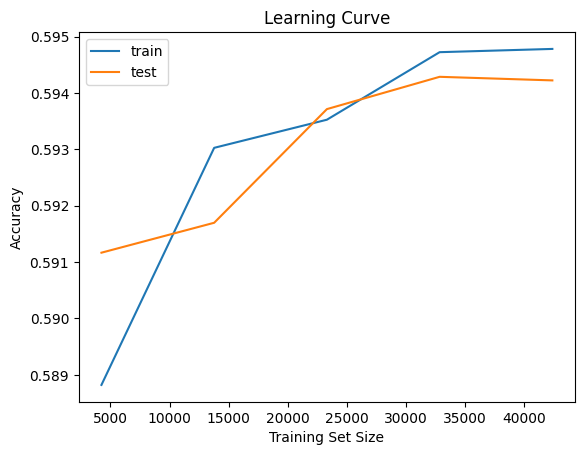

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

The learning curve shows that the training accuracy starts relatively high but decreases as more data is added, while the test accuracy remains consistently low with not much improvement. The gap between the training and test curves suggests that the model is not generalizing well to unseen data. The low performance on both training and test sets indicates that the model is suffering from high bias (underfitting). This suggests that logistic regression, as a linear model, may not be capturing the patterns in the data effectively. Due to these results, we will explore a more flexible model.

## Knn Classification

Testing our new model, KNN classification. We pick the target variable and predictor variables.

In [ ]:
predictors = ['Speed Limit'] + [col for col in data.columns if col.startswith('Weather')
                                or col.startswith('Surface Condition')
                                or col.startswith('Vehicle Body Type')]
X = data[predictors]
y = data['Injury_Binary']

Scale and split the data

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

Pick the k = 5 and apply the KNeighborsClassifier

In [ ]:
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

Printing out the confusion matrix and accuracy

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

Confusion Matrix:
[[5547 4608]
 [4274 5764]]
Accuracy: 0.560


Calculate the base line accuracy

In [ ]:
majority_class = pd.Series(y_train).value_counts().index[0]

accuracy_baseline = (majority_class == y_train).mean()
print(f"Baseline accuracy: {accuracy_baseline:.3f}")

Baseline accuracy: 0.501


Pick a random parameter to see if there is a better accuracy

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, weights='uniform', p=1)
knn.fit(X_train, y_train)
print(f"Test accuracy: {knn.score(X_test, y_test):.3f}")

knn = KNeighborsClassifier(n_neighbors=11, weights='distance', p=2)
knn.fit(X_train, y_train)
print(f"Test accuracy: {knn.score(X_test, y_test):.3f}")

knn = KNeighborsClassifier(n_neighbors=15, weights='uniform', p=1)
knn.fit(X_train, y_train)
print(f"Test accuracy: {knn.score(X_test, y_test):.3f}")


Test accuracy: 0.537
Test accuracy: 0.550
Test accuracy: 0.542


We also try the grid search cross validation to find the best parameters

In [ ]:
grid = [ {'n_neighbors': range(3,30,2),
'weights': ['uniform', 'distance'],
'p': [1,2]}
]

X_train_small = X_train[:5000]
y_train_small = y_train[:5000]

knn = KNeighborsClassifier()
knnCV = GridSearchCV(estimator=knn, param_grid=grid, cv=10, scoring='accuracy')

knnCV.fit(X_train_small, y_train_small)

print(f"Best accuracy: {knnCV.best_score_:.3f}")

print(f"Best params: {knnCV.best_params_}")

Best accuracy: 0.559
Best params: {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}


It looks like the best pramaters are 'n_neighbors': 23, 'p': 1, 'weights': 'uniform' and our accuracy is better than the baseline

In [ ]:
knnCV.cv_results_

results = pd.DataFrame(knnCV.cv_results_['params'])
results['score'] = knnCV.cv_results_['mean_test_score']
results.sort_values(by='score', ascending=False, inplace=True)
print(results)

    n_neighbors  p   weights   score
10            7  2   uniform  0.5586
52           29  1   uniform  0.5586
54           29  2   uniform  0.5584
14            9  2   uniform  0.5580
11            7  2  distance  0.5580
8             7  1   uniform  0.5578
9             7  1  distance  0.5578
12            9  1   uniform  0.5576
15            9  2  distance  0.5576
13            9  1  distance  0.5568
55           29  2  distance  0.5560
53           29  1  distance  0.5548
46           25  2   uniform  0.5532
44           25  1   uniform  0.5510
36           21  1   uniform  0.5504
38           21  2   uniform  0.5496
47           25  2  distance  0.5490
42           23  2   uniform  0.5484
45           25  1  distance  0.5478
40           23  1   uniform  0.5474
6             5  2   uniform  0.5460
18           11  2   uniform  0.5460
43           23  2  distance  0.5458
41           23  1  distance  0.5454
39           21  2  distance  0.5450
37           21  1  distance  0.5448
7

As the result showing, the accuracy score increases when the n_neighbors increases. The best p is 1 and the best weight is uniform, and the best k is 19.

## Cluster Analysis

Pick the variables for clustering and apply kmeans from Scikit Learn

In [ ]:
X = pd.get_dummies(df_balanced[['Weather', 'Injury_Binary']], columns=['Weather'], drop_first=True)
columns_to_keep = ['Injury_Binary', 'Weather_cloudy']
X = X[columns_to_keep]
kmeans = KMeans(n_clusters = 4, random_state=0)
cluster_nums = kmeans.fit_predict(X)

Visualizing the cluster centers

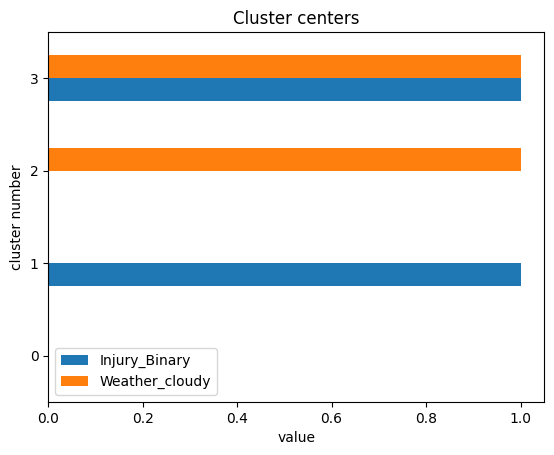

In [ ]:
feature_names = X.columns.tolist()
centers = pd.DataFrame(kmeans.cluster_centers_, columns=feature_names)
centers.plot.barh()
plt.title('Cluster centers')
plt.xlabel('value')
plt.ylabel('cluster number');

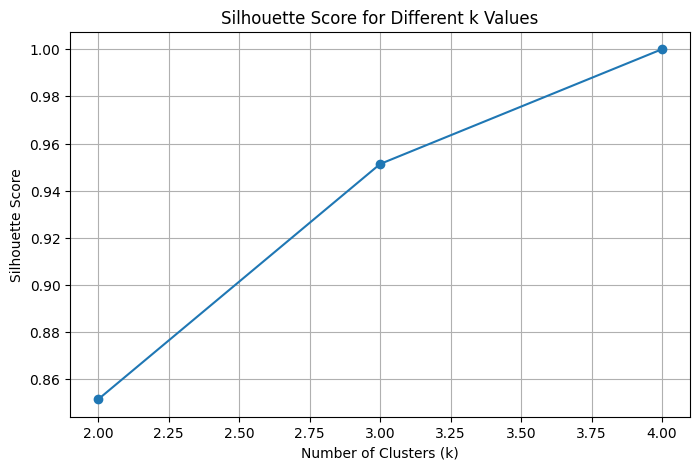

In [ ]:
silhouette_scores = []
k_values = range(2, 5)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(score)


plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Different k Values')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

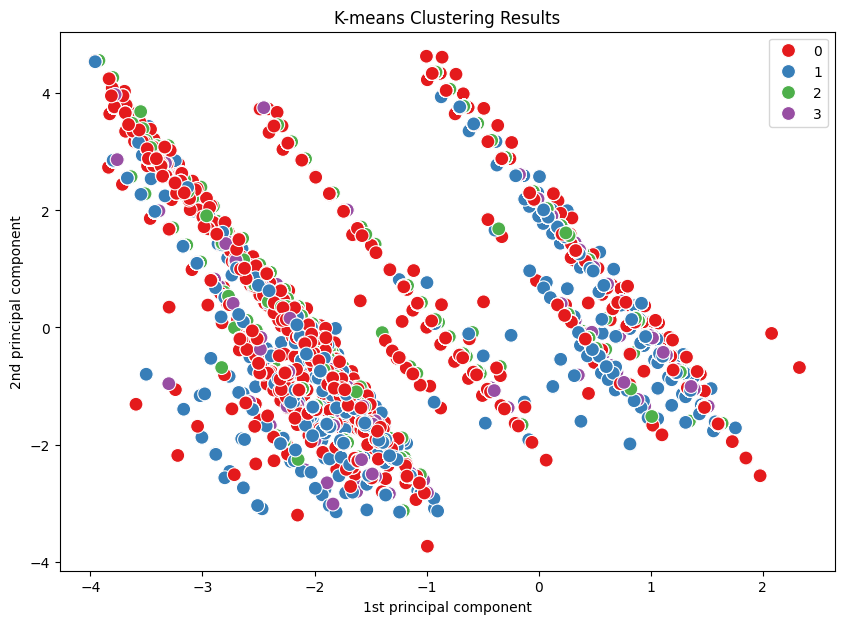

In [ ]:
pca = PCA(n_components=2).fit_transform(X_scaled)


plt.figure(figsize=(10, 7))
ax = sns.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=cluster_nums, palette='Set1', s=100)
ax.set_title('K-means Clustering Results')
ax.set_xlabel('1st principal component')
ax.set_ylabel('2nd principal component')
plt.legend()
plt.show()

# Conclusions

The objective of our project was to predict the injury severity in traffic accidents based on factors such as weather conditions, surface conditions, vehicle body type, and speed limits. By analyzing these predictor variables, we aimed to uncover patterns that could inform strategies to reduce traffic injuries and improve road safety.

During preprocessing, we addressed challenges such as missing data and class imbalance. Missing data was managed by imputing or dropping columns with excessive NA values. We also addressed the imbalance of the target variable whhich was resolved using undersampling.

We initially used a logistic regression model to predict injury severity. However, the model showed signs of high bias (underfitting), as evidenced by low training and test accuracy in the learning curve analysis, indicating that it failed to capture the complexity of the data. To improve performance, we explored a more flexible model, K-Nearest Neighbors (KNN).

The KNN model, after hyperparameter tuning, achieved an accuracy of about 59.84%, which was batter than the baseline accuracy of 50.3%. This suggests that the model effectively used the predictor variables to identify patterns associated with injury severity.

In conclusion, our project demonstrates the potential of machine learning in predicting injury severity based on crash-related factors. While the results highlight the influence of variables like speed limit, weather, and surface conditions, there is room for improvement in predictive performance.

